# Performance Analysis

Performance analysis of hill climing agents

In [2]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

Load pickled data

In [3]:
data_dir = "../src/runs/"

In [4]:
def latest_run(data_dir, agent):
    dirnames = glob('{}/{}/*'.format(data_dir, agent))
    idx = np.argmax([dirname.split('/')[-1] for dirname in dirnames])
    return dirnames[idx]

In [5]:
latest_vanilla = latest_run(data_dir, 'vanilla')
print(latest_vanilla)

../src/runs//vanilla/20181015180710


In [6]:
pkl_filename = '{}/data.pkl'.format(latest_vanilla)
os.path.exists(pkl_filename)

True

In [7]:
data = pickle.load(open(pkl_filename, 'rb'))

Review whats inside data

In [8]:
data['args']

Namespace(env='CartPole-v0', episodes=1000, gamma=1.0, goal=200, policy='vanilla', runs=1000, steps=1000)

In [9]:
all_rewards = data['all_rewards']

In [10]:
len(all_rewards)

1000

In [11]:
print(len(all_rewards[0]))
print(len(all_rewards[10]))
print(len(all_rewards[100]))

216
1
230


Lets us pandas to get stats and help with plotting

In [12]:
solved_per_run = {run:len(episodes) for run, episodes in all_rewards.items()}

In [13]:
df = pd.DataFrame.from_dict({'runs': list(solved_per_run.keys()), 'episodes': list(solved_per_run.values())})
df.head()

,runs,episodes
0,0,216
1,1,217
2,2,216
3,3,1
4,4,1


In [14]:
df.describe()

,runs,episodes
count,1000.000000,1000.000
mean,499.500000,367.374
std,288.819436,399.116
min,0.000000,1.000
25%,249.750000,1.000
50%,499.500000,217.000
75%,749.250000,912.000
max,999.000000,1000.000


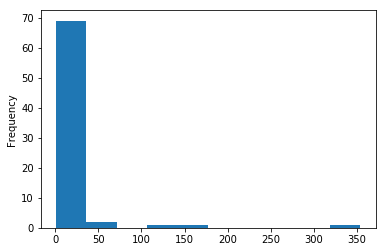

In [15]:
df['episodes'].value_counts().plot(kind='hist')

Very skewed histogram, perhaps we can do better by using log scale

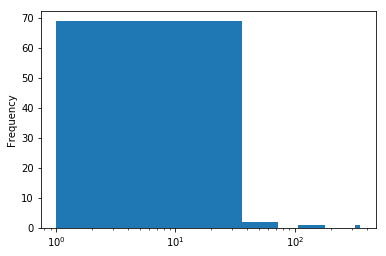

In [16]:
df['episodes'].value_counts().plot(kind='hist', logx=True)

Well, it isn't really helpful because we need to see the episodes too.

We are going to use altair to get interactive plots

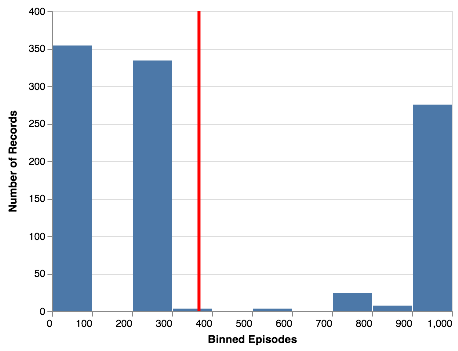

In [168]:
bar = alt.Chart(df).mark_bar().encode(
    alt.X("episodes", bin=True, title="Binned Episodes"),
    alt.Y("count(episodes)"),
#     alt.Color("count(episodes)", scale=alt.Scale(scheme="oranges"))
)

rule = alt.Chart(df).mark_rule(color='red').encode(
    x='mean(episodes)',
    size=alt.value(3)
)
#bar
bar + rule

Okay, thats better. Next, we can create helper functions to read data for each policy and generate plots

In [24]:
def plot_altair(df, title=""):
    bar = alt.Chart(df).mark_bar().encode(
        alt.X("episodes", bin=True, title="Binned Episodes"),
        alt.Y("count(episodes)"),
    #     alt.Color("count(episodes)", scale=alt.Scale(scheme="oranges"))
    ).properties(
        title=title
    )

    rule = alt.Chart(df).mark_rule(color='red').encode(
        x='mean(episodes)',
        size=alt.value(3)
    )
    #bar
    return bar + rule    

In [30]:
def plot(data_dir, agent, altair=False, title=""):
    latest_dirname = latest_run(data_dir, agent)
    pkl_filename = '{}/data.pkl'.format(latest_dirname)
    print('using pickle path: {}'.format(pkl_filename))
    data = pickle.load(open(pkl_filename, 'rb'))
    solved_per_run = {run:len(episodes) for run, episodes in data['all_rewards'].items()}
    df = pd.DataFrame.from_dict({'runs': list(solved_per_run.keys()), 'episodes': list(solved_per_run.values())})
    print(df.describe())
#     return df.plot(x='runs', y='episodes', kind='hist')
    if altair:
        chart = plot_altair(df, title)
    else:
        chart = df['episodes'].value_counts().plot(kind='hist', bins=20)
        chart.set_xlabel('Episodes required to solve the environment')
        
    return chart, df

# Random Policy

using pickle path: ../src/runs//random/20181018190608/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000   660.340000
std     288.819436   473.471858
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000  1000.000000
75%     749.250000  1000.000000
max     999.000000  1000.000000


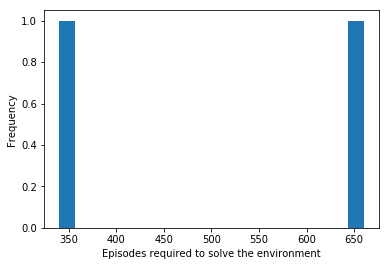

In [20]:
chart, random_df = plot(data_dir, "random")
chart

using pickle path: ../src/runs//random/20181018190608/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000   660.340000
std     288.819436   473.471858
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000  1000.000000
75%     749.250000  1000.000000
max     999.000000  1000.000000


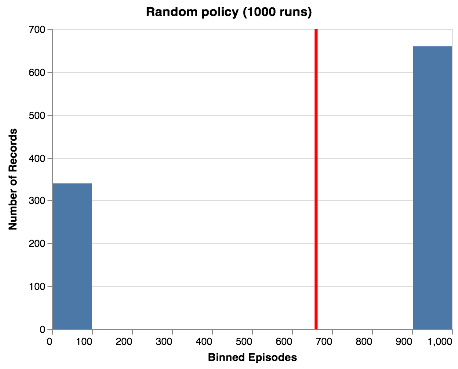

In [33]:
chart, random_df = plot(data_dir, "random", altair=True, title= "Random policy (1000 runs)")
chart

# Vanilla Hill Climbing

using pickle path: ../src/runs//vanilla/20181015180710/data.pkl
              runs  episodes
count  1000.000000  1000.000
mean    499.500000   367.374
std     288.819436   399.116
min       0.000000     1.000
25%     249.750000     1.000
50%     499.500000   217.000
75%     749.250000   912.000
max     999.000000  1000.000


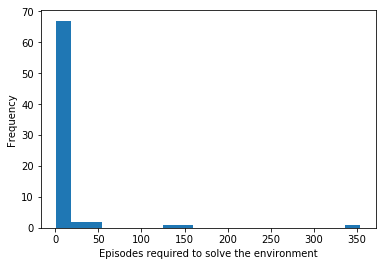

In [22]:
chart, vanilla_df = plot(data_dir, 'vanilla')
chart

using pickle path: ../src/runs//vanilla/20181015180710/data.pkl
              runs  episodes
count  1000.000000  1000.000
mean    499.500000   367.374
std     288.819436   399.116
min       0.000000     1.000
25%     249.750000     1.000
50%     499.500000   217.000
75%     749.250000   912.000
max     999.000000  1000.000


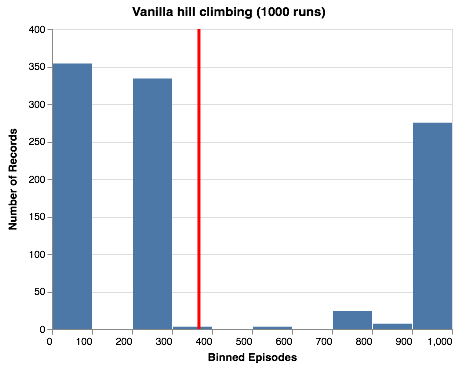

In [43]:
chart, vanilla_df = plot(data_dir, 'vanilla', altair=True, title="Vanilla hill climbing (1000 runs)")
chart

# Steepest Ascend

using pickle path: ../src/runs//steepest/20181015182144/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000    73.383000
std     288.819436    53.217821
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000   103.000000
75%     749.250000   103.000000
max     999.000000   418.000000


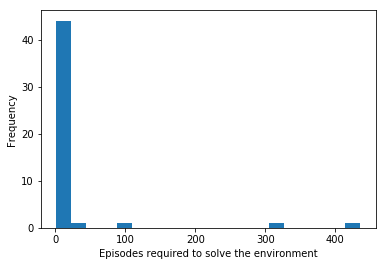

In [34]:
chart, steepest_df = plot(data_dir, 'steepest')
chart

using pickle path: ../src/runs//steepest/20181015182144/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000    73.383000
std     288.819436    53.217821
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000   103.000000
75%     749.250000   103.000000
max     999.000000   418.000000


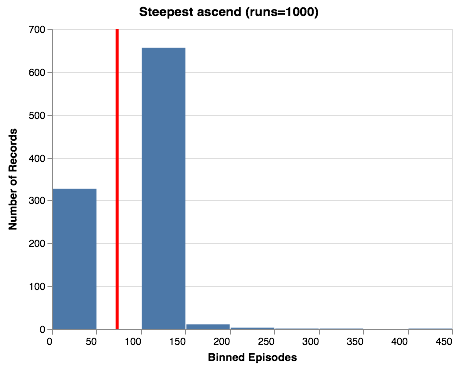

In [42]:
chart, steepest_df = plot(data_dir, 'steepest', altair=True, title="Steepest ascend (runs=1000)")
chart

# Simulated annealing

using pickle path: ../src/runs//anneal/20181015200209/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   366.85900
std     288.819436   380.82428
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   217.00000
75%     749.250000   912.00000
max     999.000000  1000.00000


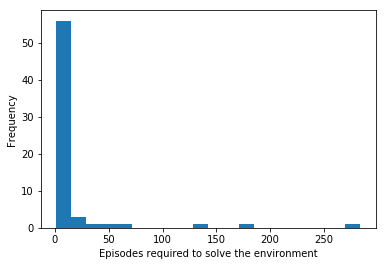

In [36]:
chart, anneal_df = plot(data_dir, 'anneal')
chart

using pickle path: ../src/runs//anneal/20181015200209/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   366.85900
std     288.819436   380.82428
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   217.00000
75%     749.250000   912.00000
max     999.000000  1000.00000


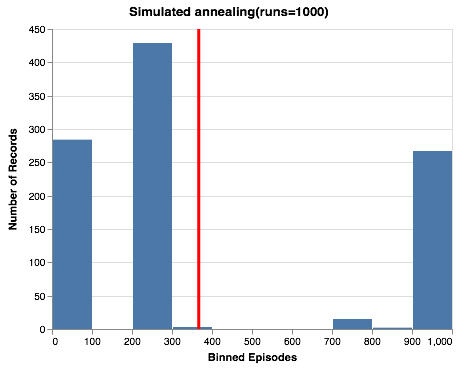

In [41]:
chart, anneal_df = plot(data_dir, 'anneal', altair=True, title="Simulated annealing(runs=1000)")
chart

# Adaptive noise scaling

using pickle path: ../src/runs//ada/20181018184103/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   346.61200
std     288.819436   422.69157
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   118.00000
75%     749.250000  1000.00000
max     999.000000  1000.00000


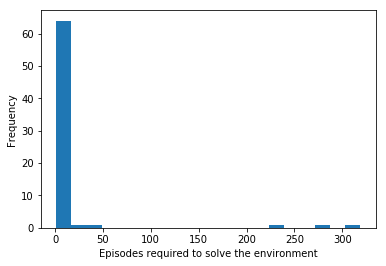

In [38]:
chart, ada_df = plot(data_dir, 'ada')
chart

using pickle path: ../src/runs//ada/20181018184103/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   346.61200
std     288.819436   422.69157
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   118.00000
75%     749.250000  1000.00000
max     999.000000  1000.00000


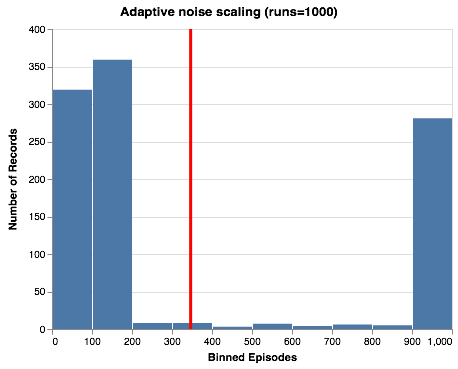

In [40]:
chart, ada_df = plot(data_dir, 'ada', altair=True, title="Adaptive noise scaling (runs=1000)")
chart

In [105]:
random_series = random_df.episodes.describe()
random_series.name = 'random'
random_series

count    1000.000000
mean      660.340000
std       473.471858
min         1.000000
25%         1.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
Name: random, dtype: float64

In [106]:
all_df = pd.DataFrame(random_series)
all_df.head()

,random
count,1000.000000
mean,660.340000
std,473.471858
min,1.000000
25%,1.000000


In [107]:
vanilla_series = vanilla_df.episodes.describe()
vanilla_series.name = 'vanilla'
vanilla_series

count    1000.000
mean      367.374
std       399.116
min         1.000
25%         1.000
50%       217.000
75%       912.000
max      1000.000
Name: vanilla, dtype: float64

In [108]:
steepest_series = steepest_df.episodes.describe()
steepest_series.name = 'steepest'
steepest_series

count    1000.000000
mean       73.383000
std        53.217821
min         1.000000
25%         1.000000
50%       103.000000
75%       103.000000
max       418.000000
Name: steepest, dtype: float64

In [109]:
anneal_series = anneal_df.episodes.describe()
anneal_series.name = 'anneal'
anneal_series

count    1000.00000
mean      366.85900
std       380.82428
min         1.00000
25%         1.00000
50%       217.00000
75%       912.00000
max      1000.00000
Name: anneal, dtype: float64

In [110]:
ada_series = ada_df.episodes.describe()
ada_series.name = 'adaptive'
ada_series

count    1000.00000
mean      346.61200
std       422.69157
min         1.00000
25%         1.00000
50%       118.00000
75%      1000.00000
max      1000.00000
Name: adaptive, dtype: float64

In [131]:
data=[random_series, vanilla_series, steepest_series, anneal_series, ada_series]

In [132]:
[d.name for d in data]

['random', 'vanilla', 'steepest', 'anneal', 'adaptive']

In [142]:
all_df = pd.DataFrame(data)

In [143]:
all_df.reset_index()

,index,count,mean,std,min,25%,50%,75%,max
0,random,1000.0,660.340,473.471858,1.0,1.0,1000.0,1000.0,1000.0
1,vanilla,1000.0,367.374,399.116000,1.0,1.0,217.0,912.0,1000.0
2,steepest,1000.0,73.383,53.217821,1.0,1.0,103.0,103.0,418.0
3,anneal,1000.0,366.859,380.824280,1.0,1.0,217.0,912.0,1000.0
4,adaptive,1000.0,346.612,422.691570,1.0,1.0,118.0,1000.0,1000.0


In [166]:
all_df['mean'].mean()

362.9136

In [156]:
all_df.to_csv('all_runs.csv')

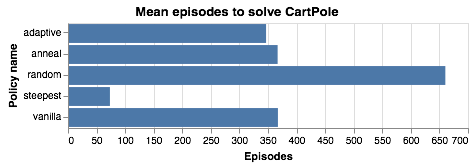

In [153]:
# Plot
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("mean", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="Mean episodes to solve CartPole"
)

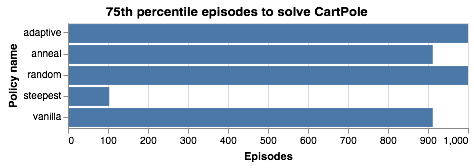

In [154]:
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("75%", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="75th percentile episodes to solve CartPole"
)

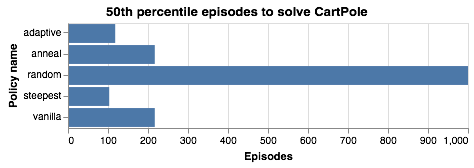

In [155]:
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("50%", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="50th percentile episodes to solve CartPole"
)